# Tutoriel : Télécharger, visualiser et interpréter les données GFS

Le GFS (Global Forecast System) est un modèle météorologique mondial développé par la NOAA (National Oceanic and Atmospheric Administration) aux États-Unis.
Il produit des prévisions pour le monde entier. Les données sont mises à jour toutes les 6 heures.
C’est une source gratuite et largement utilisée pour l’analyse et la prévision météorologique.

# Étape 1 : Importer les bibliothèques Python nécessaires

In [1]:
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.colorbar import ColorbarBase
from ipyleaflet import Map, DrawControl
import ipywidgets as widgets
from IPython.display import display
from ipyleaflet import Map, DrawControl, Rectangle
import ipywidgets as widgets
from IPython.display import display
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

print("Toutes les bibliothèques ont été importées avec succès!")

Toutes les bibliothèques ont été importées avec succès!


## Étape 2 : Sélectionner une zone d’intérêt avec une carte interactive

Avec la fonction ci-dessous, nous allons créer une carte interactive.
Sur cette carte, vous pouvez choisir vous-même la région pour laquelle vous voulez télécharger et analyser les prévisions GFS.

In [2]:
def interactive_bbox_ipy(center=(5,5), zoom=5):
    bbox_output = widgets.Output()
    m = Map(center=center, zoom=zoom, layout=widgets.Layout(width='70%', height='500px'))

    # Outil pour dessiner un rectangle sur la carte
    draw = DrawControl(
        rectangle={"shapeOptions": {"color": "#0000FF"}},
        polygon={}, circle={}, polyline={}, marker={}
    )

    current_rectangle = None
    # Objet mutable pour sauvegarder la bbox (boîte englobante)
    bbox_coords = {"lat_min": None, "lat_max": None, "lon_min": None, "lon_max": None}

    def handle_draw(self, action, geo_json):
        nonlocal current_rectangle
        coords = geo_json['geometry']['coordinates'][0]
        lons = [c[0] for c in coords]
        lats = [c[1] for c in coords]

        # Mettre à jour le dictionnaire avec les nouvelles coordonnées
        bbox_coords["lon_min"] = min(lons)
        bbox_coords["lon_max"] = max(lons)
        bbox_coords["lat_min"] = min(lats)
        bbox_coords["lat_max"] = max(lats)

        # Supprimer l’ancien rectangle (si existant)
        if current_rectangle:
            m.remove_layer(current_rectangle)

        # Ajouter le nouveau rectangle sélectionné par l’utilisateur
        current_rectangle = Rectangle(
            bounds=[[bbox_coords["lat_min"], bbox_coords["lon_min"]],
                    [bbox_coords["lat_max"], bbox_coords["lon_max"]]],
            color="blue",
            fill_opacity=0.1
        )
        m.add_layer(current_rectangle)

        # Mettre à jour le tableau avec les coordonnées
        with bbox_output:
            bbox_output.clear_output()
            display(widgets.HTML(
                value=f"""
                <table style="border:1px solid black; border-collapse: collapse;">
                <tr><th style="border:1px solid black; padding:5px">Paramètre</th>
                    <th style="border:1px solid black; padding:5px">Valeur</th></tr>
                <tr><td style="border:1px solid black; padding:5px">lat_min</td><td style="border:1px solid black; padding:5px">{bbox_coords['lat_min']:.4f}</td></tr>
                <tr><td style="border:1px solid black; padding:5px">lat_max</td><td style="border:1px solid black; padding:5px">{bbox_coords['lat_max']:.4f}</td></tr>
                <tr><td style="border:1px solid black; padding:5px">lon_min</td><td style="border:1px solid black; padding:5px">{bbox_coords['lon_min']:.4f}</td></tr>
                <tr><td style="border:1px solid black; padding:5px">lon_max</td><td style="border:1px solid black; padding:5px">{bbox_coords['lon_max']:.4f}</td></tr>
                </table>
                """
            ))

    draw.on_draw(handle_draw)
    m.add_control(draw)

    title = widgets.HTML("<h3>Sélectionnez la zone d’intérêt</h3>")
    hbox = widgets.HBox([m, bbox_output])
    layout = widgets.VBox([title, hbox])
    display(layout)

    return bbox_coords  # le dictionnaire reste disponible après avoir dessiné

# Utilisation:
bbox_coords = interactive_bbox_ipy(center=(7,0), zoom=5)


Explication pour l’utilisateur:

À gauche de la carte, vous verrez un petit carré noir. En cliquant dessus, vous pouvez dessiner un rectangle sur la carte pour choisir la zone qui vous intéresse.
Les coordonnées latitude (lat) et longitude (lon) de cette zone apparaîtront automatiquement dans un tableau à droite de la carte. Si vous souhaitez sélectionner une nouvelle région, il suffit de relancer la cellule ci-dessus.

## Étape 3 : Importer les données GFS pour la zone sélectionnée

Avec cette fonction, nous allons tracer les prévisions de précipitations du modèle GFS :
À gauche : une carte avec l’étendue complète définie par l’utilisateur.
À droite : un zoom sur la zone d’intérêt (Bounding Box) que vous avez sélectionnée

In [3]:
print('Les coordonnées lat/lon sélectionnées avec la carte interactive')
print(bbox_coords["lat_min"], bbox_coords["lat_max"], bbox_coords["lon_min"], bbox_coords["lon_max"])

def plot_gfs_forecast(hindasting, hours_ahead,
                      lat_min=4, lat_max=16, lon_min=-6, lon_max=3,
                      bbox_coords=None):
    """
    Tracer une prévision GFS avec deux panneaux :
    - Gauche : la carte complète
    - Droite : un zoom sur une boîte définie par l’utilisateur (BBox)
    
    """
    
    # Déterminer l’heure d’initialisation (0, 6, 12 ou 18 UTC)
    init_hour = max([h for h in [0, 6, 12, 18] if h <= hindasting.hour])
    init_time_str = f"{init_hour:02d}"
    date_str = hindasting.strftime("%Y%m%d")
    
    # Arrondir l’échéance au multiple de 3 le plus proche (prévisions GFS toutes les 3h)
    fh_rounded = (hours_ahead // 3) * 3
    fh_str = f"f{fh_rounded:03d}"
    
    # Construire l’URL du dataset GFS
    dataset_url = (
        f"https://thredds.rda.ucar.edu/thredds/dodsC/files/g/d084001/"
        f"{date_str[:4]}/{date_str}/gfs.0p25.{date_str}{init_time_str}.{fh_str}.grib2"
    )
    
    try:
        # Ouvrir le dataset GFS
        dataset = xr.open_dataset(dataset_url, engine="netcdf4")
        
        # Vérifier si la variable de précipitation est présente
        if "Precipitation_rate_surface" not in dataset.data_vars:
            print(f"'Precipitation_rate_surface' non disponible dans {dataset_url}")
            return
        
        # Convertir la précipitation en mm/h (valeur initiale en kg/m²/s)
        precip = dataset["Precipitation_rate_surface"] * 3600
        precip.attrs["units"] = "mm/h"
        
        # Vérifier si les données sont vides
        if precip.size == 0 or precip.isnull().all():
            print(f"Aucune donnée de précipitation disponible dans {dataset_url}")
            return
               
        # Définir une échelle discrète de couleurs
        bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]
        colors = ["none", "#add8e6", "#0000ff", "#00ff00",
                  "#ffff00", "#ffa500", "#ff0000", "#ff69b4"]
        cmap = ListedColormap(colors)
        norm = BoundaryNorm(bounds, cmap.N)
        
        # Créer une figure avec deux sous-graphes côte à côte
        fig = plt.figure(figsize=(16,6))
        gs = fig.add_gridspec(1, 2, width_ratios=[1,1], wspace=0.3)
        
        # --- Panneau gauche : carte complète ---
        ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
        precip.plot(ax=ax1, transform=ccrs.PlateCarree(),
                    cmap=cmap, norm=norm, add_colorbar=False)
        ax1.coastlines()
        ax1.add_feature(cfeature.BORDERS)
        ax1.set_extent([lon_min, lon_max, lat_min, lat_max])
        ax1.set_title(f"Carte complète\nGFS {date_str} init {init_time_str} UTC +{fh_rounded}h")
        
        # Ajouter une grille avec labels lat/lon
        gl1 = ax1.gridlines(draw_labels=True, linewidth=1, color='gray',
                            alpha=0.5, linestyle='--')
        gl1.top_labels = False
        gl1.right_labels = False
        
        # --- Panneau droit : zoom sur la BBox ---
        ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
        if bbox_coords is not None:
            ax2.set_extent([bbox_coords["lon_min"], bbox_coords["lon_max"],
                            bbox_coords["lat_min"], bbox_coords["lat_max"]])
        else:
            ax2.set_extent([lon_min, lon_max, lat_min, lat_max])
        
        precip.plot(ax=ax2, transform=ccrs.PlateCarree(),
                    cmap=cmap, norm=norm, add_colorbar=False)
        ax2.coastlines()
        ax2.add_feature(cfeature.BORDERS)
        ax2.set_title("Zoom sur la zone sélectionnée (BBox)")
        
        gl2 = ax2.gridlines(draw_labels=True, linewidth=1, color='gray',
                            alpha=0.5, linestyle='--')
        gl2.top_labels = False
        gl2.right_labels = False
        
        # --- Ajouter une barre de couleurs discrète ---
        cax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
        cbar = ColorbarBase(cax, cmap=cmap, norm=norm,
                            boundaries=bounds, spacing="uniform",
                            ticks=bounds[:-1])
        cbar.set_ticklabels(["0","0.5","2","5","10","15","25",">40"])
        cbar.set_label("Précipitation [mm/h]")
        
        plt.show()
        
    except Exception as e:
        print(f"Erreur lors de l’accès au dataset : {dataset_url}\n{e}")

Les coordonnées lat/lon sélectionnées avec la carte interactive
10.928256 14.315494 -6.180809 -1.916666


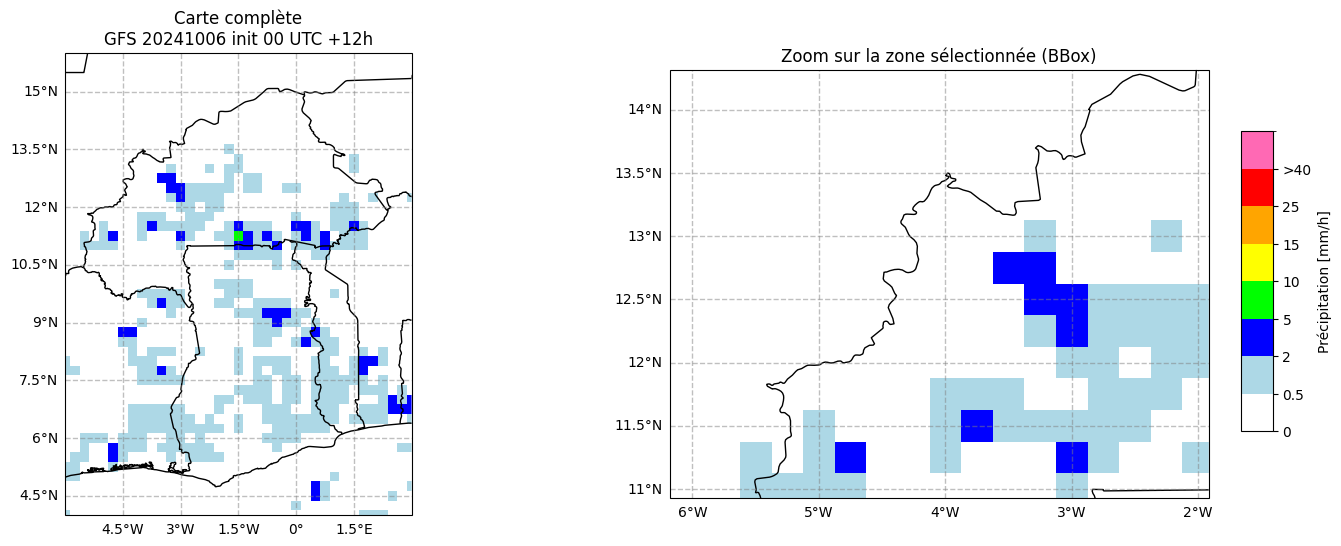

In [4]:
# Utilisation plot_gfs_forecast
hindasting = datetime.datetime(2024, 10, 6, 0)			# Choisir un moment où la prévision GFS était disponible
hours_ahead = 12				                        # Choisir le nombre d’heures à l’avance pour la prévision						

plot_gfs_forecast(
    hindasting, hours_ahead,
    lat_min=4, lat_max=16, lon_min=-6, lon_max=3,
    bbox_coords=bbox_coords
)

## Étape 4 : Importer les données GFS pour plusieurs heures de prévision
Dans cette étape, nous allons récupérer et visualiser les prévisions GFS pour plusieurs heures à l’avance à partir de l’heure d’initialisation choisie.
Vous pouvez choisir une liste d’échéances, par exemple [3, 6, 12, 18, 24] pour voir la prévision 3h, 6h, 12h, 18h et 24h après l’initialisation.
- La carte sera zoomée sur la zone que vous avez sélectionnée avec la Bounding Box interactive.
- Les couleurs indiquent l’intensité de la précipitation en mm/h.

In [5]:
def plot_gfs_forecast_series(hindasting, lead_hours_list, bbox_coords):
    # Définir la palette de couleurs pour la précipitation
    bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]
    colors = ["none", "#add8e6", "#0000ff", "#00ff00",
              "#ffff00", "#ffa500", "#ff0000", "#ff69b4"]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(bounds, cmap.N)
    
    # Nombre de panneaux = nombre d'échéances à tracer
    n_panels = len(lead_hours_list)
    fig, axes = plt.subplots(1, n_panels, figsize=(4*n_panels, 4),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    
    if n_panels == 1:
        axes = [axes]  # Pour rendre axes itérable même s'il n'y a qu'un panneau
    
    print("Récupération des prévisions GFS...")
    
    for i, fh in enumerate(tqdm(lead_hours_list, desc="Étapes de prévision")):
        # Déterminer l'heure d'initialisation du modèle
        init_hour = max([h for h in [0, 6, 12, 18] if h <= hindasting.hour])
        init_time_str = f"{init_hour:02d}"
        date_str = hindasting.strftime("%Y%m%d")
        
        # Arrondir l'échéance à un multiple de 3 (GFS produit toutes les 3h)
        fh_rounded = (fh // 3) * 3
        fh_str = f"f{fh_rounded:03d}"
        
        # Construire l'URL pour accéder au fichier GRIB de GFS
        dataset_url = (
            f"https://thredds.rda.ucar.edu/thredds/dodsC/files/g/d084001/"
            f"{date_str[:4]}/{date_str}/gfs.0p25.{date_str}{init_time_str}.{fh_str}.grib2"
        )
        
        try:
            # Ouvrir le dataset GFS
            ds = xr.open_dataset(dataset_url, engine="netcdf4")
            if "Precipitation_rate_surface" not in ds.data_vars:
                print(f"Variable précipitation non disponible dans {dataset_url}")
                continue
            
            # Extraire et convertir la précipitation en mm/h
            precip = ds["Precipitation_rate_surface"] * 3600
            
            # Sélectionner le panneau correspondant
            ax = axes[i]
            im = precip.plot(ax=ax, transform=ccrs.PlateCarree(),
                             cmap=cmap, norm=norm, add_colorbar=False)
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS)
            
            # Définir la zone du zoom selon la BBox choisie
            ax.set_extent([bbox_coords["lon_min"], bbox_coords["lon_max"],
                           bbox_coords["lat_min"], bbox_coords["lat_max"]])
            ax.set_title(f"+{fh_rounded}h")  
            
            # Ajouter les grilles avec labels lat/lon
            gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                              alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            
        except Exception as e:
            print(f"Erreur lors de l'accès à {dataset_url}: {e}")
            ax.set_visible(False)  
    
    # Barre de couleurs commune pour tous les panneaux
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    from matplotlib.colorbar import ColorbarBase
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, boundaries=bounds,
                        spacing='uniform', ticks=bounds[:-1])
    cbar.set_ticklabels(["0","0.5","2","5","10","15","25",">40"])
    cbar.set_label("Précipitation [mm/h]")
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

Récupération des prévisions GFS...


Étapes de prévision:   0%|          | 0/4 [00:00<?, ?it/s]

Étapes de prévision: 100%|██████████| 4/4 [00:25<00:00,  6.43s/it]
/tmp/ipykernel_722/2536601127.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


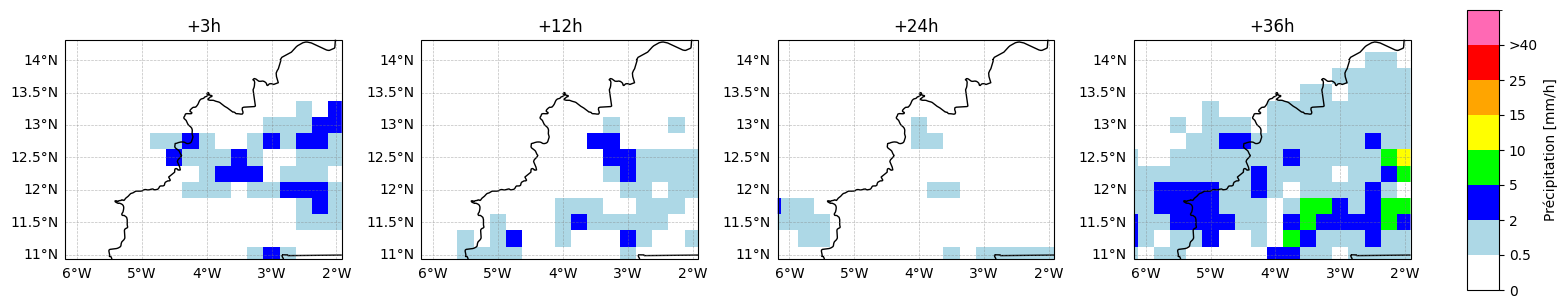

In [6]:
# Utilisation plot_gfs_forecast_series
hindasting = datetime.datetime(2024, 10, 6, 0)				# Choisir un moment où la prévision GFS était disponible
lead_hours_list = [3, 12, 24, 36]							# Liste des heures à l'avance pour lesquelles on veut la prévision
plot_gfs_forecast_series(hindasting, lead_hours_list, bbox_coords)

## Étape 5 : Créez un graphique des précipitations prévues par le GFS
Dans ce graphique, la précipitation moyenne (en mm) est calculée pour la zone sélectionnée à chaque pas de prévision GFS. De plus, grâce à une interpolation linéaire, on obtient la précipitation cumulée moyenne au fil du temps.
Attention : l’interpolation linéaire donne une idée générale des précipitations prévues, mais ne reflète pas fidèlement les variations et l’instabilité des prévisions.

In [7]:
def plot_gfs_forecast_bars_cumulative(hindasting, lead_hours_list, bbox_coords):
    """
    Trace un histogramme de l'intensité moyenne des précipitations sur le bbox avec précipitations cumulées.
    Les labels et la légende sont en français.
    """
    avg_precip_list = []
    lon_min = bbox_coords["lon_min"] % 360
    lon_max = bbox_coords["lon_max"] % 360
    lat_min = bbox_coords["lat_min"]
    lat_max = bbox_coords["lat_max"]

    for fh in tqdm(lead_hours_list, desc="Leadtimes"):
        init_hour = max([h for h in [0, 6, 12, 18] if h <= hindasting.hour])
        init_time_str = f"{init_hour:02d}"
        date_str = hindasting.strftime("%Y%m%d")
        fh_rounded = (fh // 3) * 3
        fh_str = f"f{fh_rounded:03d}"

        dataset_url = (
            f"https://thredds.rda.ucar.edu/thredds/dodsC/files/g/d084001/"
            f"{date_str[:4]}/{date_str}/gfs.0p25.{date_str}{init_time_str}.{fh_str}.grib2"
        )

        try:
            ds = xr.open_dataset(dataset_url, engine="netcdf4")
            if "Precipitation_rate_surface" not in ds.data_vars:
                avg_precip_list.append(np.nan)
                continue

            precip = ds["Precipitation_rate_surface"] * 3600
            bbox_precip = precip.sel(
                lat=slice(lat_max, lat_min),
                lon=slice(lon_min, lon_max)
            )
            avg_precip = float(bbox_precip.mean().values)
            avg_precip_list.append(avg_precip)

        except Exception as e:
            print(f"Erreur lors de l'accès à {dataset_url}: {e}")
            avg_precip_list.append(np.nan)

    # DataFrame
    df = pd.DataFrame({
        "leadtime_h": lead_hours_list,
        "avg_precip_mmph": avg_precip_list
    })

    # Précipitations cumulées (mm)
    cum_precip = [0]
    for i in range(1, len(lead_hours_list)):
        delta_h = lead_hours_list[i] - lead_hours_list[i-1]
        cum = cum_precip[-1] + avg_precip_list[i-1]*delta_h
        cum_precip.append(cum)
    df["cum_precip_mm"] = cum_precip

    # Interpolation pour la courbe cumulative
    interp_func = interp1d(df["leadtime_h"], df["cum_precip_mm"], kind="linear")

    # Plot
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.bar(df["leadtime_h"], df["avg_precip_mmph"], color='skyblue', label="Intensité moyenne [mm/h]")
    ax1.set_xlabel("Heure de prévision")
    ax1.set_ylabel("Intensité moyenne des précipitations [mm/h]")
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_xticks(lead_hours_list)
    ax1.set_xticklabels([f"+{h}h" for h in lead_hours_list])  # labels avec "+"

    # Deuxième axe y pour précipitations cumulées
    ax2 = ax1.twinx()
    leadtime_fine = np.linspace(min(lead_hours_list), max(lead_hours_list), 200)
    ax2.plot(leadtime_fine, interp_func(leadtime_fine), color='darkblue', label="Précipitations cumulées [mm]")
    ax2.set_ylabel("Précipitations cumulées [mm]")

    # Légende combinée
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left")

    plt.title(f"Prévision GFS : intensité moyenne et cumulée sur le bbox pour l'initiation {hindasting}")
    plt.show()

    return df

Leadtimes: 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


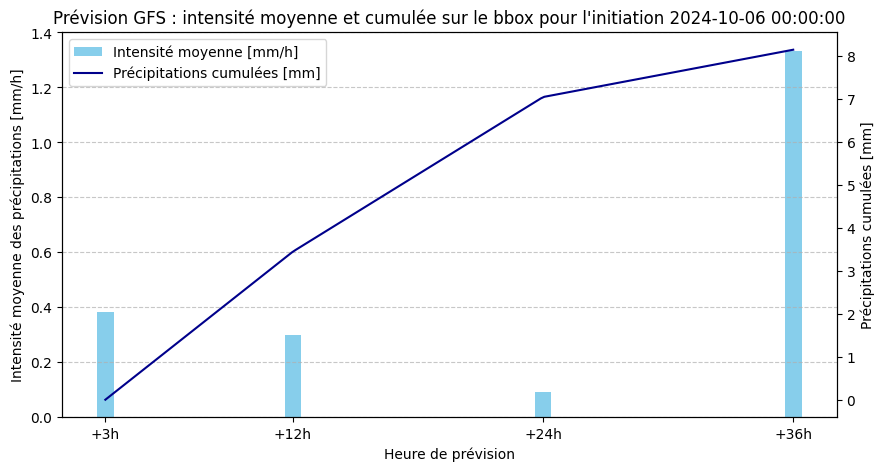

In [8]:
# Utilisation plot_gfs_forecast_bars_cumulative
hindasting = datetime.datetime(2024, 10, 6, 0)
lead_hours_list = [3, 12, 24, 36]
df_GFS = plot_gfs_forecast_bars_cumulative(hindasting, lead_hours_list, bbox_coords)

## Félicitations! Vous avez terminé le tutoriel et vous êtes désormais capable d’importer, de visualiser et de quantifier vous-même les données GFS.